(importing-data)=
# Importing receptor data into scirpy

In [1]:
# This cell is for development only. Don't copy this to your notebook.
%load_ext autoreload
%autoreload 2
import anndata

anndata.logging.anndata_logger.addFilter(
    lambda r: not r.getMessage().startswith("storing") and r.getMessage().endswith("as categorical.")
)

# Temporarily suppress FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
import tarfile
import warnings
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import scirpy as ir

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/pyth

In this notebook, we demonstrate how single-cell {term}`AIRR`-data can be imported into
an {class}`~anndata.AnnData` object and merged with gene expression data in a {class}`~mudata.MuData` container for the use with Scirpy. 
To learn more about how AIRR data is represented in AnnData, check out the {ref}`data structure <data-structure>` section.

:::{important} 
**The scirpy data model**

Since v0.13, there are no restrictions on the AIRR data that can be stored in the scirpy data structure, except that 
each receptor chain needs to be associated with a cell. However, for all analyses, the assumptions of the 
{ref}`receptor model <receptor-model>` still apply:

 * BCR and TCR chains are supported. Chain loci must be valid {term}`Chain locus`,
   i.e. one of `TRA`, `TRG`, `IGK`, or `IGL` (chains with a {term}`VJ<V(D)J>` junction) or
   `TRB`, `TRD`, or `IGH` (chains with a {term}`VDJ<V(D)J>` junction). 
 * Each cell can contain up to two `VJ` and two `VDJ` chains ({term}`Dual IR`).
   Excess chains are ignored (those with lowest read count/{term}`UMI` count)
   and cells flagged as {term}`Multichain-cell`.
 * Non-productive chains are ignored. *CellRanger*, *TraCeR*, and the *AIRR rearrangment format*
   flag these cells appropriately. When reading {ref}`custom formats <importing-custom-formats>`,
   you need to pass the flag explicitly or filter the chains beforehand.

The {func}`~scirpy.pp.index_chains` function chooses the appropriate chains for each cell according to this model 
and stores references to those chains in `adata.obsm`.
:::

:::{note}
**AIRR quality control**

 * After importing the data, we recommend running the {func}`scirpy.tl.chain_qc` function.
   It will
       1. identify the {term}`Receptor type` and {term}`Receptor subtype` and flag cells
          as `ambiguous` that cannot unambigously be assigned to a certain receptor (sub)type, and
       2. flag cells with {term}`orphan chains <Orphan chain>` (i.e. cells with only a single detected cell)
          and {term}`multichain-cells <Multichain-cell>` (i.e. cells with more than two full pairs of VJ- and VDJ-chains).
 * We recommend excluding multichain- and ambiguous cells as these likely represent doublets
 * Based on the *orphan chain* flags, the corresponding cells can be excluded. Alternatively,
   these cells can be matched to clonotypes on a single chain only, by using the `receptor_arms="any"`
   parameter when running {func}`scirpy.tl.define_clonotypes`.
:::


## Loading data from estabilshed analysis pipelines or AIRR-compliant tools

We provide convenience functions to load data from *10x CellRanger*, *BD Rhapsody*, *TraCeR*, or *BraCeR* with 
a single function call. Moreover, we support importing data in the community-standard
[AIRR rearrangement schema](https://docs.airr-community.org/en/latest/datarep/rearrangements.html).

```{eval-rst}
.. module:: scirpy.io
   :noindex:

.. autosummary::
   :toctree: ../generated

   read_10x_vdj
   read_tracer
   read_bracer
   read_airr
   read_bd_rhapsody
   from_dandelion
```

### Read 10x data

With {func}`~scirpy.io.read_10x_vdj` we can load `filtered_contig_annotations.csv` or `contig_annotations.json` files as they are produced by *CellRanger*.
Here, we demonstrate how to load paired single cell transcriptomics and TCR sequencing data from COVID19 patients
from [GSE145926](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926) {cite}`Liao2020`.

In [3]:
# Load the TCR data
adata_tcr = ir.io.read_10x_vdj("example_data/liao-2019-covid19/GSM4385993_C144_filtered_contig_annotations.csv.gz")

# Load the associated transcriptomics data
adata = sc.read_10x_h5("example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

reading example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5
 (0:00:00)


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


This particular sample only has a detected TCR for a small fraction of the cells:

In [4]:
adata_tcr.shape

(136, 0)

In [5]:
adata.shape

(3716, 33539)

Next, we integrate both the TCR and the transcriptomics data into a single {class}`~mudata.MuData` object. By convention, 
gene expression data should be stored in the `gex` modality, immune receptor data in the `airr` modality. 

In [6]:
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

Now, we can use TCR-related variables together with the gene expression data.
Here, we visualize the cells with a detected TCR on the UMAP plot.
It is reassuring that the TCRs coincide with the T-cell marker gene CD3.

In [7]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)
computing UMAP
    finished (0:00:03)


In [8]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

Filtering chains...


Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


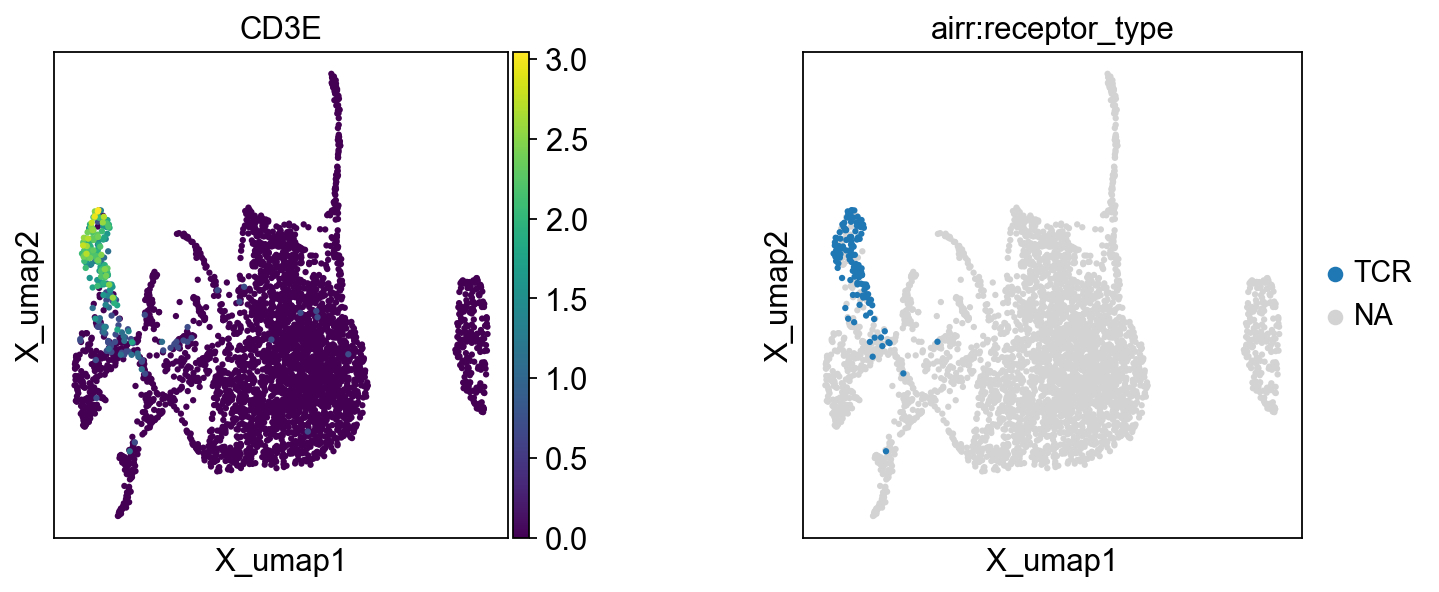

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

### Read Smart-seq2 data processed with TraCeR

[TraCeR](https://github.com/Teichlab/tracer>) {cite}`Stubbington2016-kh` is a method commonly used
to extract TCR sequences from data generated with Smart-seq2 or other full-length single-cell sequencing protocols.

The {func}`scirpy.io.read_tracer` function obtains its TCR information from the `.pkl` file
in the `filtered_TCR_seqs` folder TraCeR generates for each cell.

For this example, we load the ~500 cells from triple-negative breast cancer patients from
[GSE75688](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75688>) {cite}`Chung2017`.
The raw data has been processed using the [Smart-seq2 pipeline](https://github.com/nf-core/smartseq2/) from nf-core.

In [10]:
# extract data
with tarfile.open("example_data/chung-park-2017.tar.bz2", "r:bz2") as tar:
    tar.extractall("example_data/chung-park-2017")

First, we load the transcriptomics data from the `counts.tsv` file: 

In [11]:
expr_chung = pd.read_csv("example_data/chung-park-2017/counts.tsv", sep="\t")
# anndata needs genes in columns and samples in rows
expr_chung = expr_chung.set_index("Geneid").T
adata = sc.AnnData(expr_chung)
adata.shape

(563, 23438)

Next, we load the TCR data and merge it with the transcriptomics data:

In [12]:
adata_tcr = ir.io.read_tracer("example_data/chung-park-2017/tracer/")
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

In [13]:
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:00)
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


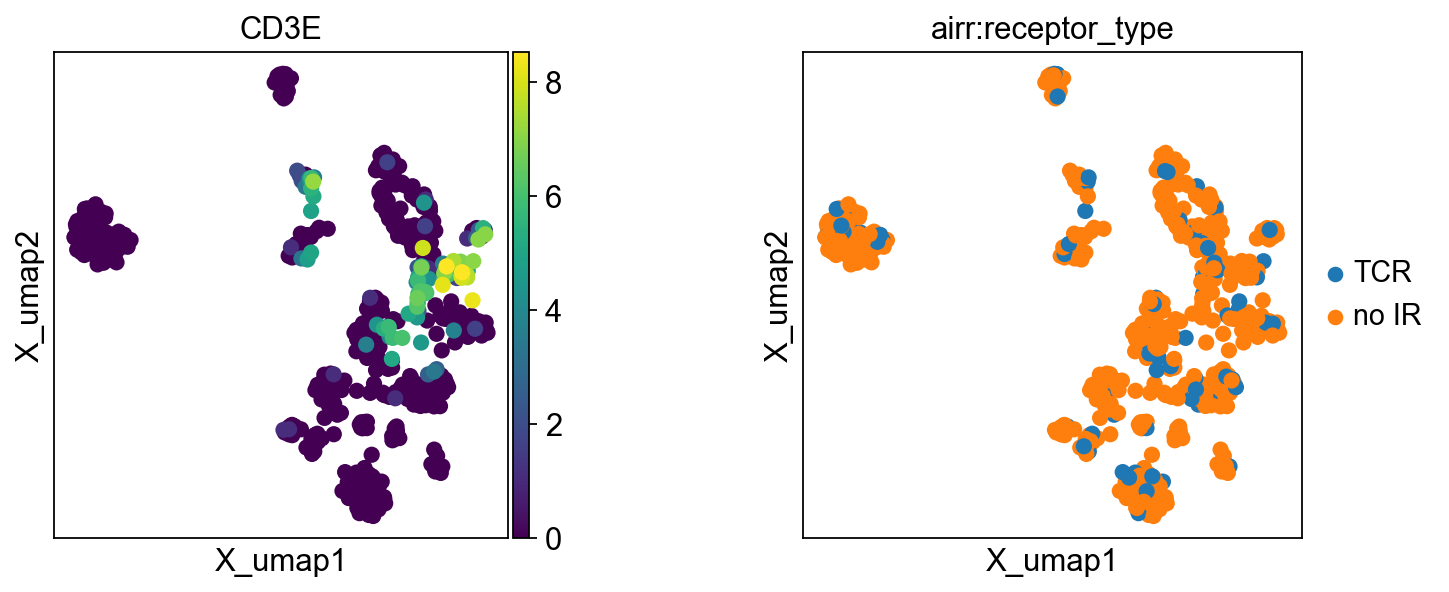

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

### Read an AIRR-compliant rearrangement table

We generated example data using [immuneSIM](https://immunesim.readthedocs.io/en/latest/) {cite}`Weber2020`. 
The data consists of 100 cells and does not include transcriptomics data.

The rearrangement tables are often organized into separate tables per chain. Therefore, {func}`scirpy.io.read_airr` supports
specifiying multiple `tsv` files at once. This would have the same effect as concatenating them before
the import.

In [15]:
adata = ir.io.read_airr(
    [
        "example_data/immunesim_airr/immunesim_tra.tsv",
        "example_data/immunesim_airr/immunesim_trb.tsv",
    ]
)
ir.pp.index_chains(adata)
ir.tl.chain_qc(adata)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.


The dataset does not come with transcriptomics data. We can, therefore, not
show the UMAP plot highlighting cells with TCRs, but we can still use scirpy
to analyse it. Below, we visualize the clonotype network
connecting cells with similar {term}`CDR3` sequences.

**Note:** The cutoff of 25 was chosen for demonstration purposes on this small sample dataset. Usually a smaller cutoff
is more approriate.

In [16]:
ir.pp.ir_dist(adata, metric="tcrdist", sequence="aa", cutoff=25)

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


Initializing lookup tables. 


Computing clonotype x clonotype distances.


100%|██████████| 100/100 [00:00<00:00, 1124.43it/s]

Stored result in `adata.obs["cc_aa_tcrdist"]`.
Stored result in `adata.obs["cc_aa_tcrdist_size"]`.


<Axes: title={'center': 'cc_aa_tcrdist'}>

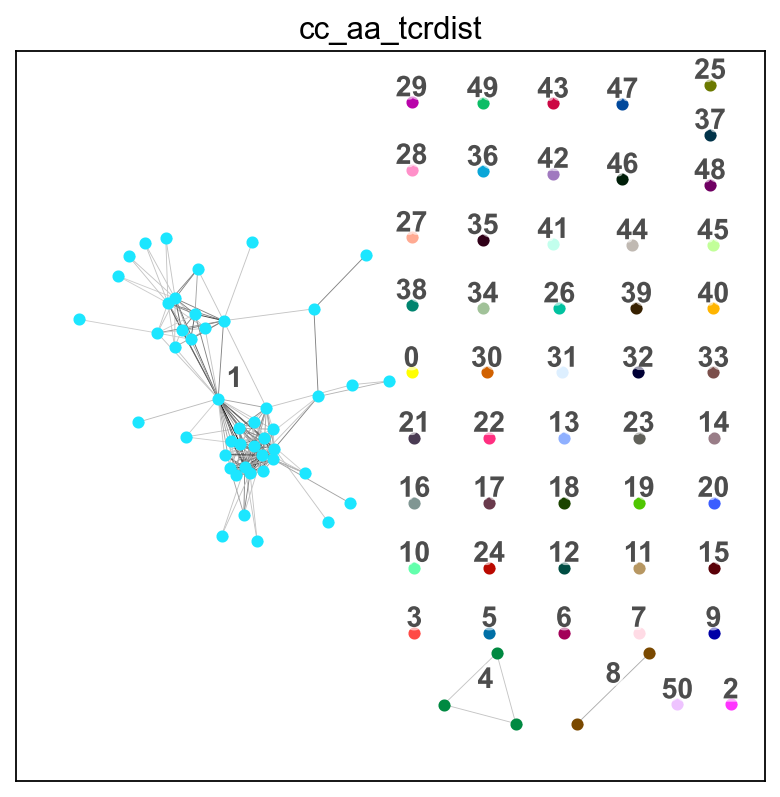

In [17]:
ir.tl.define_clonotype_clusters(
    adata,
    metric="tcrdist",
    sequence="aa",
    receptor_arms="any",
    dual_ir="primary_only",
)
ir.tl.clonotype_network(adata, size_aware=False, metric="tcrdist", sequence="aa")
ir.pl.clonotype_network(
    adata,
    color="cc_aa_tcrdist",
    base_size=20,
    panel_size=(6, 6),
    show_legend=False,
    show_size_legend=False,
)

(importing-custom-formats)=
## Creating AnnData objects from other formats

Often, immune receptor (IR) data are just provided as a simple table listing the {term}`CDR3` sequences for each cell.
We provide a generic data structure for cells with IRs, which can then be converted into
an {class}`~anndata.AnnData` object.

```{eval-rst}
.. module:: scirpy.io
   :noindex:

.. autosummary::
   :toctree: ../generated

   AirrCell
   from_airr_cells
```

If you believe you are working with a commonly used format, consider sending a [feature request](https://github.com/scverse/scirpy/issues)
for a `read_XXX` function.

For this example, we again load the triple-negative breast cancer data from {cite}`Chung2017`. However, this
time, we retrieve the TCR data from a separate summary table containing the TCR information
(we generated this table for the sake of the example, but it could very well have been a 
supplementary file from the paper).

Such a table typically contains information about

 * CDR3 sequences (amino acid and/or nucleotide)
 * The {term}`Chain locus`, e.g. `TRA`, `TRB`, or `IGH`.
 * expression of the receptor chain (e.g. count, {term}`UMI`, transcripts per million (TPM))
 * the {term}`V(D)J` genes for each chain
 * information if the chain is {term}`productive <Productive chain>`.

In [18]:
tcr_table = pd.read_csv(
    "example_data/chung-park-2017/tcr_table.tsv",
    sep="\t",
    index_col=0,
    na_values=["None"],
    true_values=["True"],
)
tcr_table

,cell_id,cdr3_alpha,cdr3_nt_alpha,count_alpha,v_alpha,j_alpha,cdr3_beta,cdr3_nt_beta,count_beta,v_beta,d_beta,j_beta,productive_alpha,productive_beta
0,SRR2973278,AVSDIHASGGSYIPT,GCTGTTTCGGATATTCATGCATCAGGAGGAAGCTACATACCTACA,9.29463,TRAV21,TRAJ6,ASSWWQNTEAF,GCCAGCAGCTGGTGGCAGAACACTGAAGCTTTC,37.5984,TRBV5-1,NaN,TRBJ1-1,True,True
1,SRR2973305,AVVTGANSKLT,GCTGTGGTAACTGGAGCCAATAGTAAGCTGACA,89.45740,TRAV22,TRAJ56,NaN,NaN,NaN,NaN,NaN,NaN,True,True
2,SRR2973371,ALKRTGNTPLV,GCTCTGAAAAGAACAGGAAACACACCTCTTGTC,431.96500,TRAV9-2,TRAJ29,ASRSRDSGEPQH,GCCAGCAGGAGCAGGGACAGCGGAGAGCCCCAGCAT,952.0230,TRBV10-2,TRBD1,TRBJ1-5,True,True
3,SRR2973377,ATDPETSGSRLT,GCTACGGACCCAGAAACCAGTGGCTCTAGGTTGACC,772.43600,TRAV17,TRAJ58,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,SRR2973403,AVRGATDSWGKFQ,GCTGTGAGAGGAGCAACTGACAGCTGGGGGAAATTCCAG,95.63640,TRAV3,TRAJ24,SVQTSEYEQY,AGCGTCCAGACTAGCGAGTACGAGCAGTAC,205.8330,TRBV29-1,TRBD2,TRBJ2-7,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,SRR5023618,NaN,NaN,NaN,NaN,NaN,ASSDSPFSSYNEQF,GCCAGCAGTGACTCGCCCTTTAGCTCCTACAATGAGCAGTTC,864.4550,TRBV6-4,NaN,TRBJ2-1,True,True
86,SRR5023621,AENSGGSNYKLT,GCAGAGAATAGTGGAGGTAGCAACTATAAACTGACA,512.63000,TRAV13-2,TRAJ53,ASSPDGGGGYT,GCCAGCAGCCCTGATGGGGGAGGGGGCTACACC,805.2010,TRBV7-3,TRBD2,TRBJ1-2,True,True
87,SRR5023626,ALRIGSNYKLT,GCTCTGAGAATCGGTAGCAACTATAAACTGACA,12.51630,TRAV9-2,TRAJ53,NaN,NaN,NaN,NaN,NaN,NaN,True,True
88,SRR5023633,NaN,NaN,NaN,NaN,NaN,ASGLGQSVGGTQY,GCTAGTGGCCTAGGGCAGTCGGTAGGAGGGACCCAGTAC,18.4273,TRBV12-5,TRBD2,TRBJ2-5,True,True


Our task is now to dissect the table into {class}`~scirpy.io.AirrCell` objects.
Each {class}`~scirpy.io.AirrCell` can have an arbitrary number of chains. A chain is simply represented as a Python
dictionary following the [AIRR Rearrangement Schema](https://docs.airr-community.org/en/latest/datarep/rearrangements.html#fields).

In [19]:
tcr_cells = []
for _, row in tcr_table.iterrows():
    cell = ir.io.AirrCell(cell_id=row["cell_id"])
    # some fields are mandatory according to the Rearrangement standard, but can be set to NULL
    # the `empty_chain_dict()` function provides a dictionary with all mandatory fields, but set to NULL.
    alpha_chain = ir.io.AirrCell.empty_chain_dict()
    beta_chain = ir.io.AirrCell.empty_chain_dict()
    alpha_chain.update(
        {
            "locus": "TRA",
            "junction_aa": row["cdr3_alpha"],
            "junction": row["cdr3_nt_alpha"],
            "consensus_count": row["count_alpha"],
            "v_call": row["v_alpha"],
            "j_call": row["j_alpha"],
            "productive": row["productive_alpha"],
        }
    )
    beta_chain.update(
        {
            "locus": "TRB",
            "junction_aa": row["cdr3_beta"],
            "junction": row["cdr3_nt_beta"],
            "consensus_count": row["count_beta"],
            "v_call": row["v_beta"],
            "d_call": row["d_beta"],
            "j_call": row["j_beta"],
            "productive": row["productive_beta"],
        }
    )
    cell.add_chain(alpha_chain)
    cell.add_chain(beta_chain)
    tcr_cells.append(cell)

Now, we can convert the list of {class}`~scirpy.io.AirrCell` objects using {func}`scirpy.io.from_airr_cells`.

In [20]:
adata_tcr = ir.io.from_airr_cells(tcr_cells)

In [21]:
# We can re-use the transcriptomics data from above...
adata = sc.AnnData(expr_chung)
# ... and merge it with the TCR data
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

In [22]:
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:00)
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


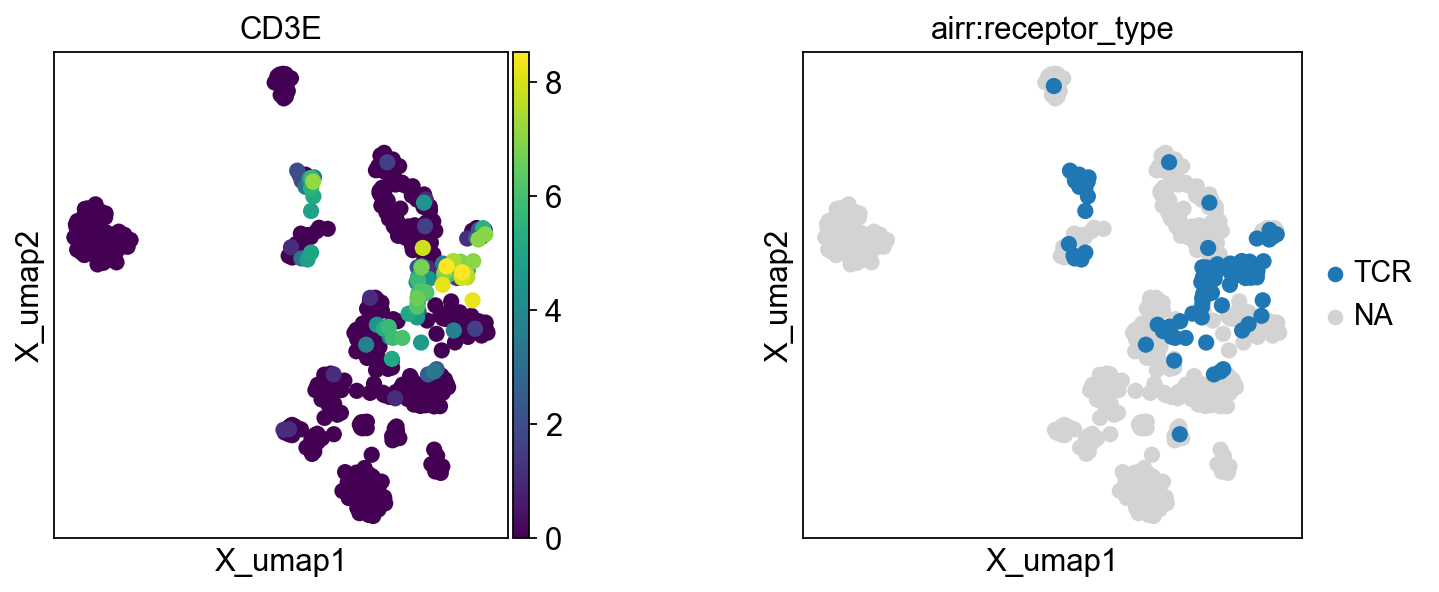

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

(combining-samples)=

## Combining multiple samples

It is quite common that the sequncing data is split up in multiple samples.
To combine them into a single object, we load each sample independently using one of the approaches described
in this document. Then, we combine them using {func}`anndata.concat`.

MuData currently does not implement a `concat` function (see [scverse/mudata#20](https://github.com/scverse/mudata/issues/20)). Therefore, we
need to first concatenate gene expression and AIRR data separately and create the MuData object as the last step. 

Here is a full example loading and combining three samples from the COVID19 study by {cite}`Liao2020`.

In [24]:
# define sample metadata. Usually read from a file.
samples = {
    "C144": {"group": "mild"},
    "C146": {"group": "severe"},
    "C149": {"group": "healthy control"},
}

In [25]:
# Create a list of AnnData objects (one for each sample)
adatas_tcr = {}
adatas_gex = {}
for sample in samples.keys():
    gex_file = glob(f"example_data/liao-2019-covid19/*{sample}*.h5")[0]
    tcr_file = glob(f"example_data/liao-2019-covid19/*{sample}*.csv.gz")[0]
    adata_gex = sc.read_10x_h5(gex_file)
    adata_tcr = ir.io.read_10x_vdj(tcr_file)
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_tcr[sample] = adata_tcr
    adatas_gex[sample] = adata_gex

reading example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5
 (0:00:00)


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading example_data/liao-2019-covid19/GSM4339774_C146_filtered_feature_bc_matrix.h5
 (0:00:00)
reading example_data/liao-2019-covid19/GSM4475052_C149_filtered_feature_bc_matrix.h5


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [26]:
# Merge anndata objects
adata_gex = anndata.concat(adatas_gex, index_unique="_")
adata_tcr = anndata.concat(adatas_tcr, index_unique="_")
mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})

# Set global metadata on `mdata.obs`
mdata.obs["sample"] = mdata.obs_names.to_series().str.split("_", expand=True)[1]
mdata.obs["group"] = mdata.obs["sample"].map(lambda x: samples[x]["group"])

/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


The data is now integrated in a single object.
Again, the detected TCRs coincide with `CD3E` gene expression.
We clearly observe batch effects between the samples -- for a meaningful downstream analysis further
processing steps such as highly-variable gene filtering and batch correction are necessary.

In [27]:
mdata

MuData object with n_obs × n_vars = 10715 × 33539
  obs:	'sample', 'group'
  2 modalities
    gex:	10706 x 33539
    airr:	581 x 0
      obsm:	'airr'

In [28]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

computing PCA
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:10)
computing UMAP
    finished (0:00:03)
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sturm/apps/micromamba/envs/scirpy_dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


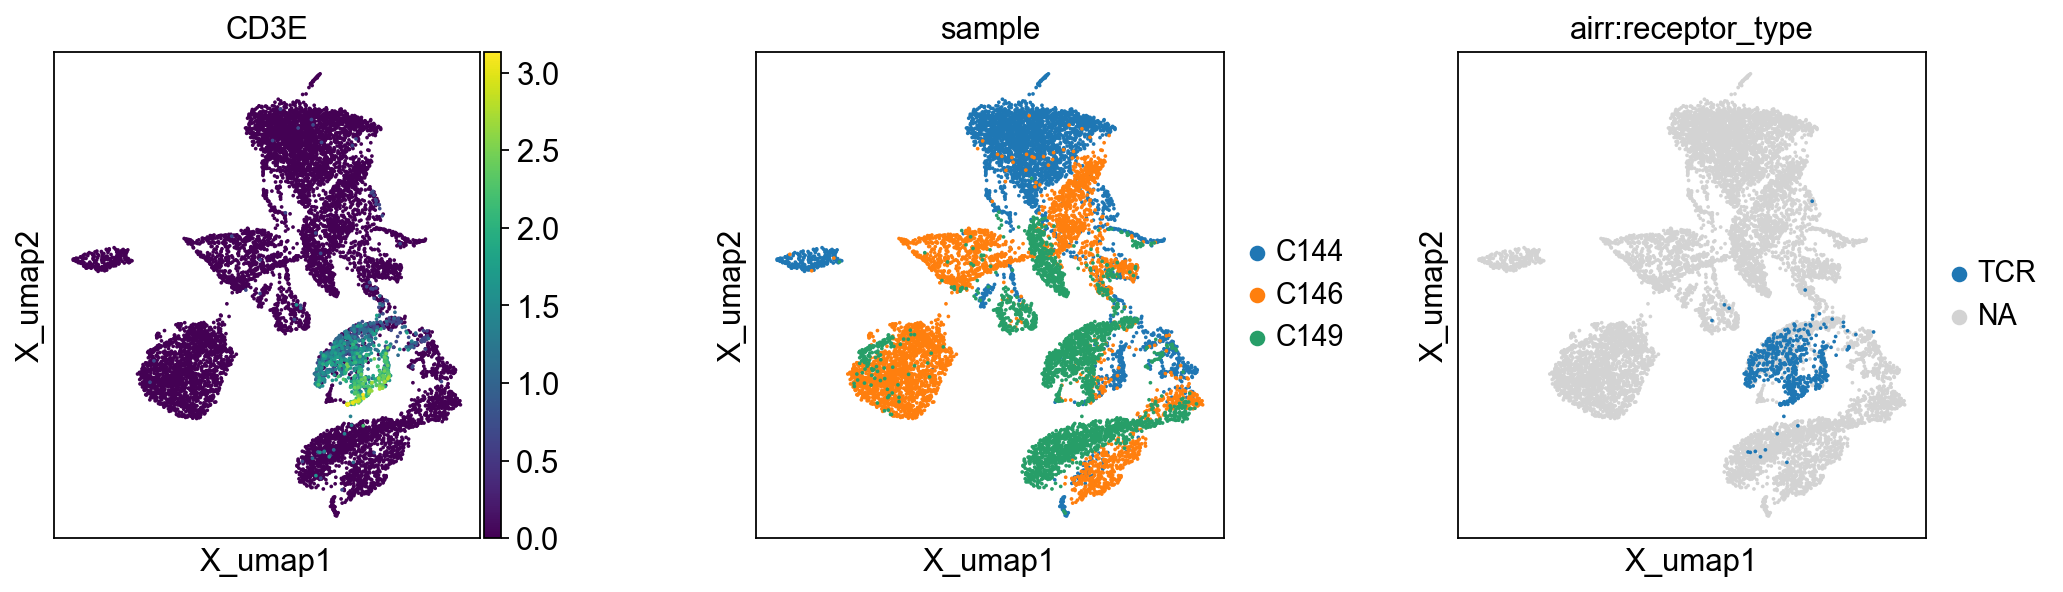

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color="CD3E", ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color="sample", ax=ax1, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color="airr:receptor_type", ax=ax2)